In [1]:
from dataclasses import dataclass
import multiprocessing
import math
import re

import numpy as np
import networkx as nx
import pulp

In [2]:
PATH = '/home/mitsuhisa.ohta/projects/cvrp/data/cvrptw/solomon/instances/c101.txt'


@dataclass
class CVRPTWInstance:
    name: str
    n_vehicles: int
    capacity: float
    customers: np.ndarray
    dist: np.ndarray

    @property
    def n_customers(self):
        return len(self.customers)


def load_instance(path):
    data = [line.strip() for line in open(path)]
    for i, line in enumerate(data):
        if i == 0:
            name = line
        elif line == 'VEHICLE':
            number, capacity = map(int, re.split(r'\s+', data[i + 2]))

        if line == 'CUSTOMER':
            customers = np.array([
                    tuple(map(float, re.split(r'\s+', l)))
                    for l in data[i + 3:]
                ],
                dtype=[
                    ('id', int),
                    ('x', float),
                    ('y', float),
                    ('demand', float),
                    ('ready_time', float),
                    ('due_time', float),
                    ('service_time', float)
                ]
            )
            x = customers['x']
            y = customers['y']
            dist = np.array([[
                    np.linalg.norm([x[i] - x[j], y[i] - y[j]])
                    for j in range(len(customers))
                ]
                for i in range(len(customers))
            ])
    return CVRPTWInstance(name=name, n_vehicles=number, capacity=capacity, customers=customers, dist=dist)

instance = load_instance(PATH)

ユーティリティ関数

In [3]:
@np.vectorize
def fix_value(x, value):
    x.bounds(value, value)
    return x


@np.vectorize
def get_values(x):
    return x.value()


@np.vectorize
def set_category(x, cat, initial_value=None):
    x.cat = cat
    if initial_value:
        x.setInitialValue(initial_value)
    return x


def get_solver(msg=True, time_limit=None, warm_start=True):
    if pulp.GUROBI_CMD().available():
        return pulp.GUROBI_CMD(msg=msg, warmStart=warm_start, timeLimit=time_limit)
    elif pulp.MIPCL_CMD().available():
        return pulp.MIPCL_CMD(msg=msg, timeLimit=time_limit)
    elif pulp.COIN_CMD().available():
        return pulp.COIN_CMD(msg=msg, warmStart=warm_start, threads=multiprocessing.cpu_count(), timeLimit=time_limit)
    else:
        return pulp.PULP_CBC_CMD(msg=True, warmStart=warm_start, threads=multiprocessing.cpu_count(), timeLimit=time_limit)

# TSP を解く

In [4]:
def build_model(instance, relax=False):
    cat = 'Continuous' if relax else 'Binary'
    n = instance.n_customers

    prob = pulp.LpProblem()

    x = np.array(pulp.LpVariable.matrix('x', (range(n), range(n)), 0, 1, cat=cat))
    fix_value(np.diagonal(x), 0)

    objective = pulp.lpSum(instance.dist*x)
    prob.setObjective(objective)

    for i in range(n):
        prob.addConstraint(pulp.lpSum(x[i, :]) == 1)
        prob.addConstraint(pulp.lpSum(x[:, i]) == 1)

    return prob, x

In [5]:
%%time

solver = get_solver(time_limit=5*60)

prob, x = build_model(instance, relax=True)
prob.solve(solver)

while True:
    graph = nx.from_numpy_array(get_values(x))
    cycles = list(nx.connected_components(graph))
    if len(cycles) == 1:
        if prob.isMIP():
            break
        print('start to solve original problem.')
        set_category(x, pulp.LpInteger, 0)
        prob.solve(solver)
        continue
    print(len(cycles))

    for cycle in cycles:
        prob.addConstraint(pulp.lpSum(x[list(cycle)][:, list(cycle)]) <= len(cycle) - 1)

    pulp.LpStatus[prob.solve(solver)]

46
17
23
17
3
start to solve original problem.
5
5
4
4
4
3
3
3
2
2
2
2
CPU times: user 4.61 s, sys: 195 ms, total: 4.81 s
Wall time: 1min


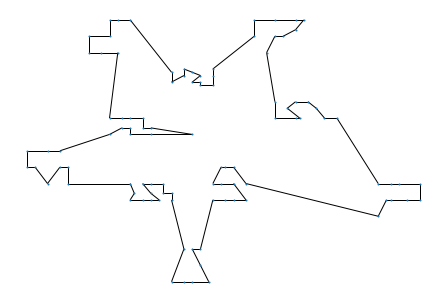

In [6]:
graph = nx.from_numpy_array(get_values(x))
nx.draw(graph, list(zip(instance.customers['x'], instance.customers['y'])), node_size=1)

## MTZ定式化

$$ \min\quad \sum D_{ij}x_{ij}\\
s.t. \\
\begin{aligned}
\sum_{j}x_{ij} &= 1, \\
\sum_{j}x_{ji} &= 1, \\
u_i + 1 - (N - 1)(1 - x_{ij}) &\leq u_{j} \quad j \neq 0.
\end{aligned}
$$

In [7]:
def build_mtz_model(instance):
    n = instance.n_customers
    prob = pulp.LpProblem()

    x = np.array(pulp.LpVariable.matrix('x', (range(n), range(n)), cat=pulp.LpBinary))
    u = np.array(pulp.LpVariable.matrix('u', (range(n),), 0, n - 1, cat=pulp.LpContinuous))
    fix_value(np.diagonal(x), 0)
    fix_value(u[:1], 0)

    objective = pulp.lpSum(instance.dist[:n, :n]*x)
    prob.setObjective(objective)

    for i in range(n):
        prob.addConstraint(pulp.lpSum(x[i, :]) == 1)
        prob.addConstraint(pulp.lpSum(x[:, i]) == 1)

    for i in range(n):
        for j in range(1, n):
            prob.addConstraint(u[i] + 1 - (n - 1)*(1 - x[i, j]) <= u[j])

    return prob, x

In [8]:
%%time

mtz_prob, x_mtz = build_mtz_model(instance)
solver = get_solver(time_limit=5*60)
pulp.LpStatus[mtz_prob.solve(solver)]

CPU times: user 636 ms, sys: 25.5 ms, total: 661 ms
Wall time: 5min


'Not Solved'

## 単品種フロー定式化

$$ \min\quad \sum D_{ij}x_{ij}\\
s.t. \\
\begin{aligned}
\sum_{j}x_{ij} &= 1, \\
\sum_{j}x_{ji} &= 1, \\
\sum_{j}f_{0j }&= N - 1,\\
\sum_{j}f_{ji} - \sum_{j}f_{ij} &= 1.\quad i \neq 0\\
f_{ij} &\leq (N-1)x_{ij}.
\end{aligned}
$$

In [9]:
def build_flow_model(instance):
    n = instance.n_customers
    prob = pulp.LpProblem()

    x = np.array(pulp.LpVariable.matrix('x', (range(n), range(n)), cat=pulp.LpBinary))
    f = np.array(pulp.LpVariable.matrix('f', (range(n), range(n)), 0, n - 1, cat=pulp.LpContinuous))
    fix_value(np.diagonal(x), 0)
    fix_value(np.diagonal(f), 0)

    prob.setObjective(pulp.lpSum(instance.dist[:n, :n]*x))

    for i in range(n):
        prob.addConstraint(pulp.lpSum(x[i, :]) == 1)
        prob.addConstraint(pulp.lpSum(x[:, i]) == 1)

    prob.addConstraint(pulp.lpSum(f[0, :]) == n - 1)

    for i in range(1, n):
        prob.addConstraint(pulp.lpSum(f[:, i]) - pulp.lpSum(f[i, :]) == 1)

    for i in range(n):
        for j in range(n):
            if i != j:
                prob.addConstraint(f[i, j] <= (n - 1)*x[i, j])

    return prob, (x, f)

In [10]:
%%time

flow_prob, (x, f) = build_flow_model(instance)
solver = get_solver(time_limit=10*60)
pulp.LpStatus[flow_prob.solve(solver)]

KeyboardInterrupt: 

In [11]:
graph = nx.from_numpy_array(get_values(x))
nx.draw(graph, list(zip(instance.customers['x'], instance.customers['y'])), node_size=1)

TypeError: Unknown numpy data type: object

# VRP への拡張

デポ(idx=0)をm台が出発する条件をつける

## 


In [19]:
def build_vrp_model(instance, relax=False):
    cat = 'Continuous' if relax else 'Binary'
    n = 60 #instance.n_customers

    prob = pulp.LpProblem()

    x = np.array(pulp.LpVariable.matrix('x', (range(n), range(n)), 0, 1, cat=cat))
    fix_value(np.diagonal(x), 0)

    objective = pulp.lpSum(instance.dist[:n, :n]*x)
    prob.setObjective(objective)

    for i in range(1, n):
        prob.addConstraint(pulp.lpSum(x[i, :]) == 1)
        prob.addConstraint(pulp.lpSum(x[:, i]) == 1)

    prob.addConstraint(pulp.lpSum(x[0, :]) <= instance.n_vehicles)
    prob.addConstraint(pulp.lpSum(x[:, 0]) <= instance.n_vehicles)

    return prob, x

In [25]:
%%time

capacity = instance.capacity/5 # instance.capacity
solver = get_solver(time_limit=5*60)

er = get_solver(time_limit=5*60)

prob, x = build_vrp_model(instance, relax=False)
prob.solve(solver)

while True:
    graph = nx.from_numpy_array(get_values(x))
    cycles = list(nx.connected_components(graph))
    if len(cycles) == 1:
        if prob.isMIP():
            break
        print('start to solve original problem.')
        set_category(x, pulp.LpInteger, 0)
        print(pulp.LpStatus[prob.solve(solver)])
        continue
    print(len(cycles))
    print(cycles)

    for cycle in cycles:
        cycle.discard(0)
        n_vehicles = math.ceil(instance.customers['demand'][list(cycle)].sum()/capacity)
        prob.addConstraint(pulp.lpSum(x[list(cycle)][:, list(cycle)]) <= len(cycle) - n_vehicles)

    print(pulp.LpStatus[prob.solve(solver)])

26
[{0}, {1, 2}, {3, 5, 7}, {4, 6}, {8, 9}, {10, 11}, {16, 12, 14}, {13, 15, 17, 18, 19}, {20, 21, 22}, {26, 23}, {24, 25}, {27, 29}, {28, 30}, {35, 31}, {32, 33}, {34, 36}, {37, 38, 39}, {40, 41}, {42, 44}, {43, 47}, {48, 45, 46}, {49, 52}, {50, 51}, {53, 54}, {57, 59, 55}, {56, 58}]
Optimal
22
[{0}, {1, 2, 4}, {3, 5}, {6, 7}, {8, 9, 10, 11}, {12, 13}, {14, 15}, {16, 19}, {17, 18}, {20, 21, 22, 23, 24}, {25, 27}, {26, 28}, {29, 30}, {32, 31}, {33, 34}, {35, 37, 38}, {36, 39}, {40, 41, 42}, {43, 44, 45, 46, 47, 48, 49, 50, 51, 52}, {56, 53}, {54, 55}, {57, 58, 59}]
Optimal
20
[{0}, {1, 2, 5}, {3, 4}, {9, 6}, {8, 10, 11, 7}, {12, 15}, {16, 17, 18, 13}, {19, 14}, {20, 21, 23, 24, 26, 27, 28, 29, 30}, {25, 22}, {32, 33, 34, 35, 36, 37, 38, 39, 31}, {40, 44}, {41, 43}, {42, 45, 46}, {49, 47}, {48, 51}, {50, 52}, {58, 53}, {57, 59, 54}, {56, 55}]
Optimal
15
[{0}, {1, 2, 3, 4, 5, 7, 9, 10, 11}, {8, 6}, {17, 18, 19, 12}, {13, 14}, {16, 15}, {20, 21, 22, 23, 25, 26, 28}, {24, 32, 27}, {33, 34,

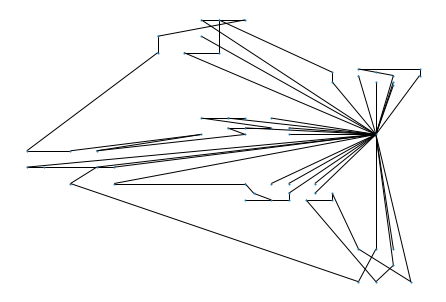

In [26]:
graph = nx.from_numpy_array(get_values(x))
nx.draw(graph, list(zip(instance.customers['x'], instance.customers['y'])), node_size=1)

In [14]:
%%time

solver = get_solver(time_limit=5*60)

er = get_solver(time_limit=5*60)

prob, x = build_vrp_model(instance, relax=False)
prob.solve(solver)

while True:
    graph = nx.from_numpy_array(get_values(x))
    graph.remove_node(0)
    cycles = list(nx.connected_components(graph))
    n_vehicles = np.sum(get_values(x)[0] > 0)
    if len(cycles) == n_vehicles:
        if prob.isMIP():
            break
        print('start to solve original problem.')
        set_category(x, pulp.LpInteger, 0)
        print(pulp.LpStatus[prob.solve(solver)])
        continue
    print(len(cycles))

    for cycle in cycles:
        n_vehicles = math.ceil(instance.customers['demand'][list(cycle)].sum()/instance.capacity)
        prob.addConstraint(pulp.lpSum(x[list(cycle)][:, list(cycle)]) <= len(cycle) - n_vehicles)

    print(pulp.LpStatus[prob.solve(solver)])


45
Optimal
26
Optimal
16
Optimal
9
Optimal
16
Optimal
6
Optimal
3
Optimal
11
Optimal
6
Optimal
9
Optimal
4
Optimal
6
Optimal
3
Optimal
5
Optimal
8
Optimal
7
Optimal
6
Optimal
6
Optimal
6
Optimal
9
Optimal
6
Optimal
9
Optimal
5
Optimal
6
Optimal
9
Optimal
4
Optimal
6
Optimal
5
Optimal
7
Optimal
7
Optimal
5
Optimal
6
Optimal
5
Optimal
5
Optimal
6


KeyboardInterrupt: 

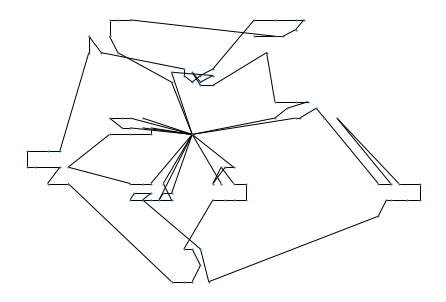

In [262]:
graph = nx.from_numpy_array(get_values(x))
nx.draw(graph, list(zip(instance.customers['x'], instance.customers['y'])), node_size=1)

In [15]:
%%time

solver = get_solver(time_limit=5*60)

prob, x = build_vrp_model(instance, relax=False)
prob.solve(solver)

while True:
    graph = nx.from_numpy_array(get_values(x))
    graph.remove_node(0)
    cycles = list(nx.connected_components(graph))
    if len(cycles) == get_values(x)[0].sum():
        if prob.isMIP():
            break
        print('start to solve original problem.')
        set_category(x, pulp.LpInteger, 0)
        print(pulp.LpStatus[prob.solve(solver)])
        continue
    print(len(cycles))

    for cycle in cycles:
        n_nodes = len(cycle)
        if n_nodes >= 2:
            demands = instance.customers['demand'][list(cycle)].sum()
            v = math.ceil(demands/instance.capacity)
            prob.addConstraint(pulp.lpSum(x[list(cycle)][:, list(cycle)]) <= len(cycle) - v)

    print(pulp.LpStatus[prob.solve(solver)])

45
Optimal
26
Optimal
16
Optimal
9
Optimal
16
Optimal
6
Optimal
3
Optimal
11
Optimal
6
Optimal
9
Optimal
5
Optimal
6
Optimal
3
Optimal
5
Optimal
8
Optimal
7
Optimal
5
Optimal
8
Optimal
5
Optimal
7
Optimal
7
Optimal
9
Optimal
8
Optimal
9
Optimal
8
Optimal
7
Optimal
5
Optimal
CPU times: user 8.4 s, sys: 346 ms, total: 8.75 s
Wall time: 3min 13s


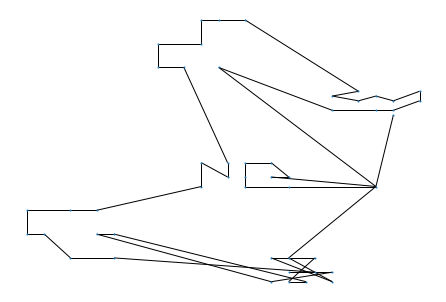

In [227]:
graph = nx.from_numpy_array(get_values(x))
nx.draw(graph, list(zip(instance.customers['x'], instance.customers['y'])), node_size=1)

## Flow を使った定式化

In [111]:
def build_cvrp_model(instance, relax=False):
    cat = 'Continuous' if relax else 'Binary'
    n = 51 #instance.n_customers

    prob = pulp.LpProblem()

    x = np.array(pulp.LpVariable.matrix('x', (range(n), range(n)), 0, 1, cat=cat))
    f = np.array(pulp.LpVariable.matrix('f', (range(n), range(n)), 0, instance.capacity, cat=pulp.LpContinuous))
    fix_value(np.diagonal(x), 0)
    fix_value(np.diagonal(f), 0)

    objective = pulp.lpSum(instance.dist[:n, :n]*x)
    prob.setObjective(objective)

    for i in range(1, n):
        prob.addConstraint(pulp.lpSum(x[i, :]) == 1)
        prob.addConstraint(pulp.lpSum(x[:, i]) == 1)

    for i in range(n):
        for j in range(1, n):
            prob.addConstraint(pulp.lpSum(f[i, j]) <= instance.capacity*x[i, j])

    for i in range(1, n):
        prob.addConstraint(pulp.lpSum(f[:, i]) - instance.customers['demand'][i] == pulp.lpSum(f[i, :]))

    prob.addConstraint(pulp.lpSum(x[0, :]) <= instance.n_vehicles)
    prob.addConstraint(pulp.lpSum(x[:, 0]) <= instance.n_vehicles)

    return prob, (x, f)

In [115]:
%%time

solver = get_solver(time_limit=10*60)

prob, (x, f) = build_cvrp_model(instance, relax=False)
prob.solve(solver)

KeyboardInterrupt: 

# Column Generation


## index

$r$: ルート

## Main Problem

$$
\begin{aligned}
\min\quad\sum_{r}C_{r}z_{r} \\
s.t.\quad\sum_{r}A_{ir}z_{r} &\leq 1, \quad i \neq 0\\
z_{r}&\in \{0, 1\}.
\end{aligned}
$$

## Dual Problem


$$
\begin{aligned}
\max\quad\sum_{i}y_{i} \\
s.t.\quad C_{r} -\sum_{i}A_{ir}y_{i} &\geq 0, \\
y_{i} &\geq 0.
\end{aligned}
$$

## Sub Problem

$$
\begin{aligned}
\min\quad\sum_{ij}D_{ij}x_{ij} -\sum_{i}A_{ir}y^\ast_{i} \\
s.t.\quad
\sum_{j}x_{ji} &= z_{i}, \\
\sum_{j}x_{ij} &= z_{i}, \\
\sum_{j}x_{0j} &= 1, \\
\sum_{j}x_{j0} &= 1, \\
\sum_{i}Q_{i}z_{i} &\leq CAP,\\
x_{ij} &\in \{0, 1\}, \\
z_{i} &\in \{0, 1\}.
\end{aligned}
$$



In [ ]:
def get_route(instance, y):
    nodes = list(instance.get_nodes())

    model = pulp.LpProblem(sense=pulp.LpMaximize)
    x = np.array(pulp.LpVariable.matrix('x', (nodes, nodes), cat=pulp.LpBinary))
    z = np.array(pulp.LpVariable.matrix('x', (nodes,), cat=pulp.LpBinary))

    